**Names:** Govardhan Digumurthi

---



In [ ]:
import sys
!pip install pyspark
from pyspark import SparkContext, SparkConf
import matplotlib.pyplot as plt
sc = SparkContext("local","Project3-K-means++") #Importing all the libraries required for this project

In [ ]:
#This should be used only when running this on google colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#import the input file. Please change the path as per your computer requirements
file1 = '/content/gdrive/My Drive/CS5683/data.txt'
fileRDD = sc.textFile(file1, minPartitions=20) #I have parallelized the operation

In [ ]:
items = fileRDD.map(lambda line:line.split())#To split each line into individual number

data = items.map(lambda x: [float(i) for i in x]).zipWithIndex().map(lambda x:(x[1],x[0])) # Added an identity number for each row of input data

In [ ]:
columns = len(items.take(1)[0]) #Taking the number of columns and rows from the data

In [ ]:
centroids = items.map(lambda x: [float(i) for i in x]).takeSample(False, 1) #randomly choose one point as the initial centroid
centroids[0] = (0,centroids[0]) # adding the identification for the centroid
k= 10
while len(centroids) < k: # Iterates till the number of centroids is equal to 10
  def distance(x):
    list1 = []
    for j in centroids: #for each point the centroids
      count = 0
      for i in range(0,columns): #calculates the distance between two points
        count = count + (j[1][i]-x[1][i]) * (j[1][i]-x[1][i])
      list1.append([j[0],count])
    return (x[0],list1)
  max_distance = data.map(distance).map(lambda a: (a[0], max((x for x in a[1]), key=lambda k:k[1]))).max(key = lambda x: x[1][1]) #This gives the point with maximum distance to any of the available centroids
  new_centroid = data.filter(lambda x: x[0] == max_distance[0]).map(lambda x: (len(centroids), x[1])).collect() # This collects the new centroids from the data
  centroids = centroids + new_centroid # add new centroids to the centroids list

In [ ]:
centroids_list = sc.broadcast(centroids) # broadcasting the centroids list
centroids_list_man = sc.broadcast(centroids)

In [ ]:
with open("/content/gdrive/My Drive/CS5683/Kmeansplusplus_centroids.txt", 'w') as output: # to output the centroids selected using the Kmeans++ initialization process
    for row in centroids_list.value:
        output.write(str(row) + '\n')

The process of cost function optimization is similar to the K-means from here below.

In [ ]:
def Euclidian_distance(x):
  list1 = []
  for j in centroids_list.value:
    count = 0
    for i in range(0,columns):
      count = count + (j[1][i]-x[1][i]) * (j[1][i]-x[1][i])
    count = count**.5 #"{:.2f}".format(6.737391260718053)
    list1.append([j[0],count])
  return (x[0],list1)

In [ ]:
maxiterations = 20
cost_functions_eu = {}
for i in range(0,maxiterations):
  assigned_clusters = data.map(Euclidian_distance).map(lambda a: (a[0], min((x for x in a[1]), key=lambda k:k[1])))
  #print(assigned_clusters.take(2))
  cost_function_eu = assigned_clusters.map(lambda x: x[1][1]*x[1][1]).sum()
  cost_functions_eu[i+1]  = cost_function_eu
  #new_centroids
  new_centroids = assigned_clusters.join(data).map(lambda x: (x[1][0][0],x[1][1])).groupByKey().map(lambda x: (x[0], list(x[1]))).map(lambda c: (c[0], [sum(col)/len(col) for col in zip(*c[1])]))
  #print(centroids1.take(2))
  centroids_list = sc.broadcast(new_centroids.collect())
  print('iter #' + str(i+1) + ' : ' + str(cost_function_eu))

iter #1 : 1481369859.6874902
iter #2 : 944314892.8021094
iter #3 : 708579445.1948843
iter #4 : 612308959.8910787
iter #5 : 567224353.4249852
iter #6 : 552052655.4618627
iter #7 : 547899978.9566836
iter #8 : 542600768.7680935
iter #9 : 541729018.7117785
iter #10 : 541385138.6757677
iter #11 : 541352793.5835643
iter #12 : 541333810.2743198
iter #13 : 541313766.2138975
iter #14 : 541300769.0025487
iter #15 : 541296695.7046793
iter #16 : 541294768.3806859
iter #17 : 541294768.3806859
iter #18 : 541294768.3806859
iter #19 : 541294768.3806859
iter #20 : 541294768.3806859


In [ ]:
perc_change = (cost_functions_eu[1]-cost_functions_eu[10])/cost_functions_eu[1]
perc_change

0.6345374957271115

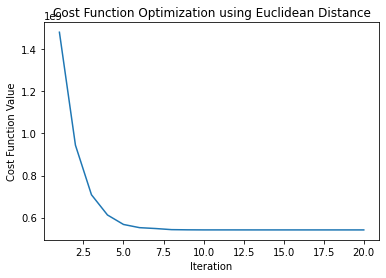

In [ ]:
plt.title('Cost Function Optimization using Euclidean Distance')
plt.ylabel('Cost Function Value')
plt.xlabel('Iteration')
plt.plot(list(cost_functions_eu.keys()),list(cost_functions_eu.values()))

In [ ]:
def manhattan_distance(x):
  list1 = []
  for j in centroids_list_man.value:
    count = 0
    for i in range(0,columns):
      count = count + abs(j[1][i]-x[1][i])
    count = count**.5 #"{:.2f}".format(6.737391260718053)
    list1.append([j[0],count])

  return (x[0],list1)

In [ ]:
maxiterations = 20
cost_functions_man = {}
for i in range(0,maxiterations):
  assigned_clusters_man = data.map(manhattan_distance).map(lambda a: (a[0], min((x for x in a[1]), key=lambda k:k[1])))#centroids1.cartesian(data).map(distance).groupByKey().map(lambda x: (x[0], list(x[1]))).map(lambda a: (a[0], min((x for x in a[1]), key=lambda k:k[1])))
  #print(assigned_clusters.take(2))
  cost_function_man = assigned_clusters_man.map(lambda x: x[1][1]*x[1][1]).sum()
  cost_functions_man[i+1]  = cost_function_man
  #new_centroids
  new_centroids_man = assigned_clusters_man.join(data).map(lambda x: (x[1][0][0],x[1][1])).groupByKey().map(lambda x: (x[0], list(x[1]))).map(lambda c: (c[0], [sum(col)/len(col) for col in zip(*c[1])]))
  #print(centroids1.take(2))
  centroids_list_man = sc.broadcast(new_centroids_man.collect())
  print('iter #' + str(i+1) + ' : ' + str(cost_function_man))

iter #1 : 1222726.3519999995
iter #2 : 1006780.4769967038
iter #3 : 969807.3506933704
iter #4 : 999497.3838805864
iter #5 : 1046566.4986158977
iter #6 : 1087600.9215269026
iter #7 : 1114111.8295630834
iter #8 : 1130197.6295729678
iter #9 : 1146814.5765926572
iter #10 : 1165782.6947791637
iter #11 : 1173420.747853379
iter #12 : 1179138.813758026
iter #13 : 1182744.6729112603
iter #14 : 1183469.97533879
iter #15 : 1183469.97533879
iter #16 : 1183469.97533879
iter #17 : 1183469.97533879
iter #18 : 1183469.97533879
iter #19 : 1183469.97533879
iter #20 : 1183469.97533879


In [ ]:
perc_change_man = (cost_functions_man[1]-cost_functions_man[10])/cost_functions_man[1]
perc_change_man

0.04657105584392919

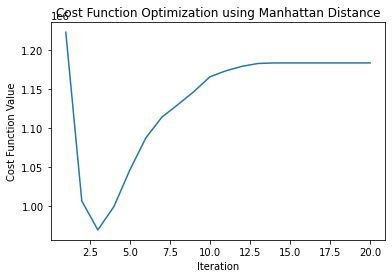

In [ ]:
plt.title('Cost Function Optimization using Manhattan Distance')
plt.ylabel('Cost Function Value')
plt.xlabel('Iteration')
plt.plot(list(cost_functions_man.keys()),list(cost_functions_man.values()))

**Reasoning for 4 and 5**


In the K-means++ initialization method, we can notice that the cost function between euclidean distance metric and manhattan distance has a reasonable change after 10 iterations. It is noticed that euc;idean cost function has a greater improvement than the manhattan cost function that reduces the intra-cluster variance indicating better performance

It is observed that using the K-means++ initialization, the manhattan and euclidean cost functions are exhibiting a greater changes in the cost function after 10 iterations when compared to K-means which reveal that there is good chance of getting to convergence (the minimum cost function) in less number of iteratons.